In [1]:
#!dcm2niix -h
#!dcm2niix Brain_T1_scan_Patient1

In [2]:
#!pip install nibabel

In [8]:
import nibabel as nib

file_path = "Nifti_Brain/Brain_T1_scan_Patient1_Sag_T1_MPRAGE_1x1x1_20210108134957_2.nii"
img=nib.load(file_path)
data=img.get_fdata()

In [37]:
print(data.shape)

(156, 256, 256)


In [9]:
#Rotate images
for i in range(len(data)):
    data[i] = np.rot90(data[i],axes=(-2,-1))

3662.0
0.0
5326.0
0.0


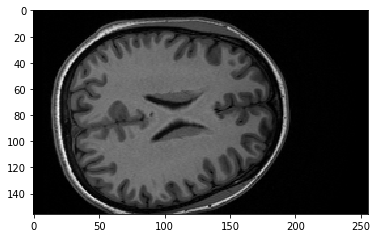

In [47]:
import matplotlib.pyplot as plt
import numpy as np


#plt.imshow(data[50], interpolation='nearest')
plt.imshow(data[:,65], cmap='gray')
plt.show()


In [48]:
grey_im = (data[50]*(255/data[50].max())).astype(np.uint8)

In [49]:
print(grey_im.max())

255


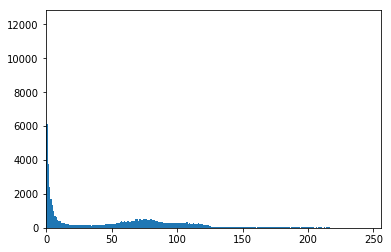

In [50]:
#https://stackoverflow.com/questions/22159160/python-calculate-histogram-of-image
counts, bins = np.histogram(grey_im, range(256))
# plot histogram centered on values 0..255

plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.show()

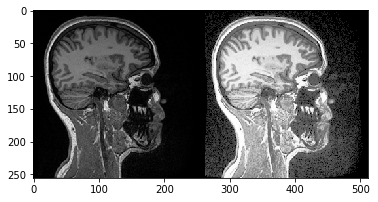

10


In [51]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
import cv2


img = grey_im
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side

plt.imshow(res, cmap='gray')
plt.show()
print(img[200][200])

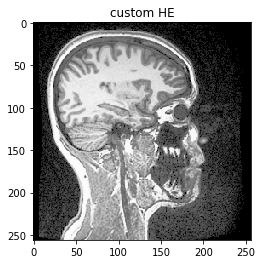

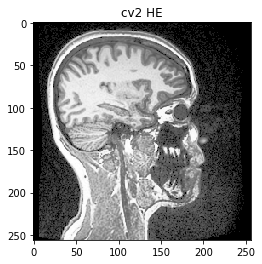

In [52]:
#Own implementation of the histogram equalization

#The goal of the H.E is to have a linear cumulative distribution function (cdf)
#a cross the range of intensity to have a better use of all possible intensities.
#
import math


def hist_equalizer(img):
    
    result = np.zeros(img.shape).astype(np.uint8)
    
    #Set the range of intensity of the image between 0 and 255 and as unsigned integers
    grey_im = (img*(255/img.max())).astype(np.uint8)
    
    #Create the histogram
    #We got up to 256 because the last bin is [255,256] while all the others are [n-1,n[
    #meaning that the last bin would have sum the pixels with value 254 and 255 if we had stop at 255
    counts, bins = np.histogram(grey_im.flatten(),256, [0,256])
    
    #Create the cdf
    cdf = counts.cumsum()
    cdf_min = cdf[np.nonzero(cdf)[0][0]] #first element that is not zero
    
    i_max, j_max = img.shape
    
    for i in range(i_max):
        for j in range(j_max):
            #value in the original image to be transformed
            val = grey_im[i][j]

            #we just take the normalized cdf of the value by the inverse distribution 
            #function (quantile function) multiply it by 255 (the max range) and round the result
            result[i][j] = math.floor((cdf[val] - cdf_min)/(i_max*j_max - cdf_min)*(256-1))

    return result

custom_res = hist_equalizer(data[50])

plt.imshow(custom_res,cmap='gray')
plt.title("custom HE")
plt.show()

plt.imshow(equ,cmap='gray')
plt.title("cv2 HE")
plt.show()

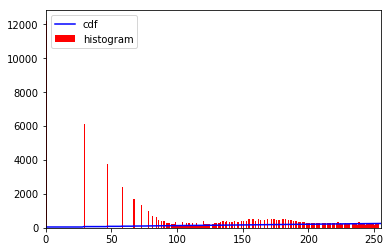

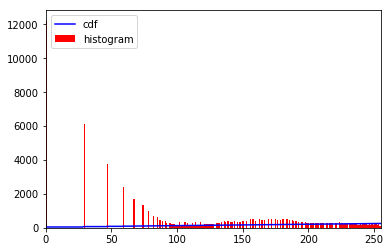

In [53]:
#Comparing histogram of custom and cv2 histogram equalizer

hists, bins = np.histogram(custom_res, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(custom_res.flatten(), 256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

hists, bins = np.histogram(equ, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

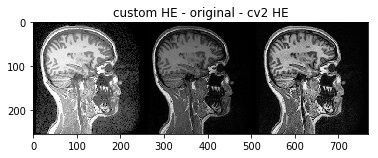

In [54]:
#Contrast-limited adaptive histogram equalization (CLAHE) consist of dividing the image into tiles
#and apply the equalization localy. There is also a threshold to limit the contrast
#TODO better explanation

img = grey_im
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #grid of 8 by 8
cl1 = clahe.apply(img)
res = np.hstack((custom_res,img,cl1))
plt.imshow(res, cmap='gray')
plt.title('custom HE - original - cv2 HE')
plt.show()

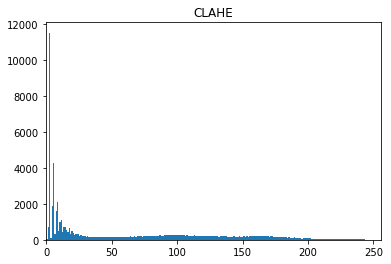

In [55]:
counts, bins = np.histogram(cl1, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("CLAHE")
plt.show()

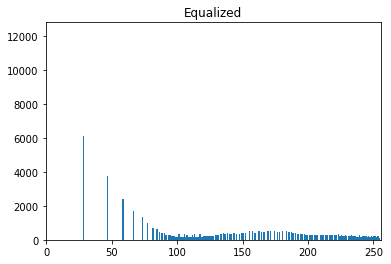

In [56]:
counts, bins = np.histogram(equ, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("Equalized")
plt.show()

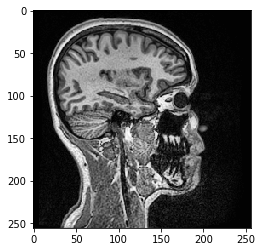

In [57]:
plt.imshow(cl1, cmap='gray')
plt.show()

(156, 256)


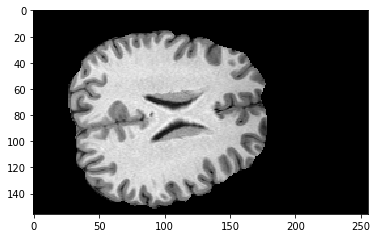

(39936, 1)


In [111]:
#Kmeans segmentation
from sklearn.cluster import KMeans

file_path = "Nifti_Brain/BrainMask.nii"
img=nib.load(file_path)
data=img.get_fdata()
image = data[:,:,190]


dim = image.shape
print(dim)

plt.imshow(image, cmap='gray')
plt.show()

img_1D = np.reshape(image,(-1,1))
print(img_1D.shape)

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=10000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(img_1D)

In [112]:
print(y_km.shape)

(39936,)


In [113]:
final = np.reshape(y_km, dim)

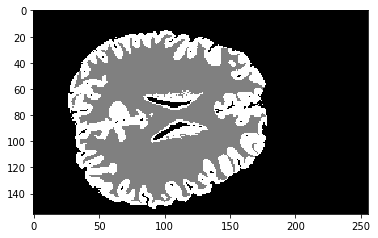

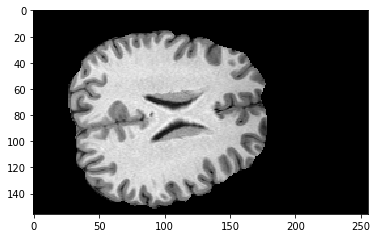

In [114]:
plt.imshow(final, cmap='gray')
plt.show()

plt.imshow(image, cmap='gray')
plt.show()